# Mask R-CNN - Train on Coco Dataset


In [3]:
# Import Python Packages
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Import Mobile Mask R-CNN Packages
from mrcnn.config import Config
from samples.coco import coco
from mrcnn import model as modellib,utils,visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Coco Dataset directory
COCO_DIR = os.path.join(ROOT_DIR, 'data/coco')

## Configurations

In [4]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # GPU
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # COCO has 80 classes (1+80)

    # Architecture
    ARCH = "mobilenetv1"
    BACKBONE_STRIDES = [2, 4, 8, 16, 32]

    # Input Resolution
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    
config = CocoConfig()
config.display()


Configurations:
ARCH                           mobilenetv1
BACKBONE_STRIDES               [2, 4, 8, 16, 32]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
M

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [6]:
# Training Dataset
classes = ['person']
dataset_train = coco.CocoDataset()
dataset_train.load_coco(COCO_DIR, "train", class_names=classes)
dataset_train.prepare()

# Validation Dataset
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val", class_names=classes)
dataset_val.prepare()

loading annotations into memory...
Done (t=14.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


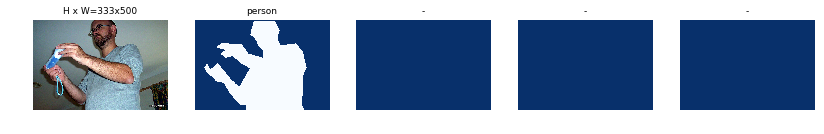

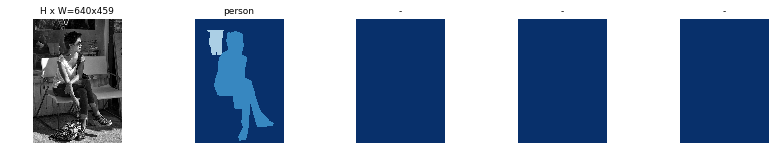

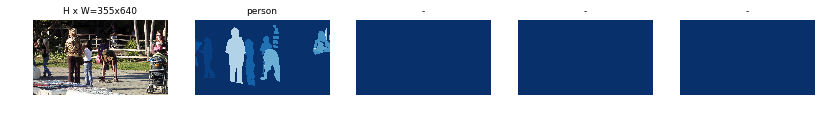

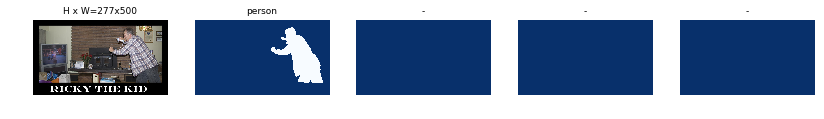

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", model_dir = MODEL_DIR, config=config)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
# Which weights to start with?
init_weights = "imagenet"  # imagenet, coco, or last

if init_weights == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_weights == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_weights == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [11]:
# Augmentation
augmentation = imgaug.augmenters.Fliplr(0.5)

In [12]:
# Training - Stage 1
# Finetune network heads
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=160,
            layers='heads',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/gustav/workspace/Mobile_Mask_RCNN/logs/coco20180418T1630/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
('In model: ', 'rpn_model')
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000347256.jpg', 'height': 398, 'id': 347256, 'annotations': [{u'segmentation': [[6.27, 282.81, 8.07, 325.84, 23.31, 338.39, 64.54, 324.05, 86.05, 289.98, 102.19, 242.48, 117.43, 263.09, 130.87, 268.47, 166.73, 270.26, 228.58, 272.06, 259.06, 245.16, 310.15, 247.85, 317.32, 241.58

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000512918.jpg', 'height': 480, 'id': 512918, 'annotations': [{u'segmentation': [[554.53, 104.9, 557.49, 98.97, 574.29, 86.12, 594.06, 64.38, 608.88, 44.62, 634.57, 30.79, 639.51, 27.82, 640.0, 69.32, 616.78, 81.18, 603.94, 94.03, 607.89, 114.78, 595.04, 112.8, 580.22, 121.69, 564.41, 117.74, 558.48, 111.81, 555.52, 107.86]], u'area': 3374.190000000002, u'iscrowd': 0, u'image_id': 512918, u'bbox': [554.53, 27.82, 85.47, 93.87], u'category_id': 1, u'id': 195748}]}
Traceback (most recent call last):
  File "mrcnn/model.py", line 2200, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mrcnn/model.py", line 1722, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "mrcnn/utils.py", line 456, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py

ERROR:root:Error processing image {'source': 'coco', 'width': 480, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000543065.jpg', 'height': 640, 'id': 543065, 'annotations': [{u'segmentation': [[168.34, 406.35, 158.19, 346.85, 163.99, 312.02, 148.03, 300.41, 158.19, 240.91, 179.95, 185.76, 252.52, 145.12, 275.74, 137.87, 290.25, 126.26, 278.64, 120.45, 272.83, 95.78, 272.83, 87.07, 275.74, 87.07, 278.64, 56.6, 290.25, 31.93, 325.08, 5.8, 371.52, 8.71, 400.54, 39.18, 390.39, 95.78, 378.78, 149.48, 367.17, 179.95, 409.25, 206.08, 423.76, 238.0, 413.61, 322.18, 378.78, 354.1, 355.56, 417.96]], u'area': 75019.6704, u'iscrowd': 0, u'image_id': 543065, u'bbox': [148.03, 5.8, 275.73, 412.16], u'category_id': 1, u'id': 443253}, {u'segmentation': [[32.83, 183.75, 30.28, 164.39, 29.55, 156.35, 21.14, 155.62, 16.76, 155.62, 13.83, 155.25, 10.55, 144.66, 10.55, 129.67, 14.56, 124.19, 16.03, 115.79, 13.47, 104.1, 13.83, 89.12, 15.66, 85.83, 26.62, 83.27, 37.22, 88.38, 40.1

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000322261.jpg', 'height': 427, 'id': 322261, 'annotations': [{u'segmentation': [[170.41, 327.59, 232.38, 359.54, 263.37, 400.21, 292.41, 388.59, 310.81, 375.04, 430.87, 323.72, 447.33, 288.86, 457.02, 245.29, 472.51, 220.12, 465.73, 188.16, 457.98, 173.64, 427.97, 150.4, 442.49, 123.29, 449.27, 102.96, 449.27, 84.56, 439.59, 71.01, 431.84, 59.39, 412.48, 51.64, 389.24, 55.51, 367.94, 59.39, 342.76, 79.72, 340.83, 113.61, 346.63, 156.21, 341.79, 160.08, 310.81, 191.07, 302.1, 212.37, 311.78, 237.54, 322.43, 250.13, 304.03, 268.53, 265.3, 285.96, 240.13, 303.39, 214.95, 309.2, 186.87, 307.26, 168.48, 315.97]], u'area': 46280.088750000024, u'iscrowd': 0, u'image_id': 322261, u'bbox': [168.48, 51.64, 304.03, 348.57], u'category_id': 1, u'id': 199510}, {u'segmentation': [[127.62, 109.39, 183.27, 115.15, 220.7, 113.23, 241.81, 116.11, 256.2, 131.46, 261.

ERROR:root:Error processing image {'source': 'coco', 'width': 500, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000214463.jpg', 'height': 338, 'id': 214463, 'annotations': [{u'segmentation': [[139.07, 61.38, 138.5, 50.53, 145.36, 47.39, 144.78, 41.39, 144.5, 35.39, 144.5, 28.54, 146.5, 27.4, 152.21, 28.25, 157.07, 31.68, 159.92, 42.53, 161.35, 46.25, 164.21, 46.53, 168.21, 53.96, 171.35, 59.96, 172.78, 61.67, 175.06, 63.1, 178.77, 72.24, 149.64, 80.52, 145.93, 71.95, 141.07, 65.95]], u'area': 1180.28605, u'iscrowd': 0, u'image_id': 214463, u'bbox': [138.5, 27.4, 40.27, 53.12], u'category_id': 1, u'id': 2000364}, {u'segmentation': [[205.04, 63.35, 178.32, 72.14, 176.91, 66.16, 177.26, 57.72, 171.28, 59.83, 167.06, 50.34, 166.01, 35.22, 173.74, 28.89, 170.93, 18.69, 173.74, 15.17, 182.89, 17.28, 185.7, 26.42, 195.55, 26.78, 200.12, 37.32, 201.17, 42.6, 200.82, 49.98]], u'area': 1403.0939999999998, u'iscrowd': 0, u'image_id': 214463, u'bbox': [166.01, 15.17, 39

ERROR:root:Error processing image {'source': 'coco', 'width': 427, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000579229.jpg', 'height': 640, 'id': 579229, 'annotations': [{u'segmentation': [[408.93, 390.22, 407.18, 395.49, 406.93, 398.75, 407.18, 400.5, 408.18, 404.51, 408.93, 408.02, 408.93, 414.29, 409.44, 422.06, 409.44, 428.08, 407.18, 432.85, 402.41, 437.11, 401.91, 440.12, 398.65, 443.63, 396.9, 445.38, 396.15, 446.14, 393.39, 445.13, 390.38, 444.63, 387.12, 443.63, 385.62, 442.12, 382.36, 439.87, 383.11, 438.61, 381.85, 428.08, 381.6, 420.06, 381.35, 417.3, 381.6, 416.3, 381.6, 414.54, 379.35, 413.29, 381.85, 406.77, 389.38, 400.25, 391.13, 395.49, 393.89, 394.98, 395.64, 394.98, 395.64, 392.48, 396.9, 389.47, 397.65, 387.71, 399.66, 385.71, 403.67, 385.21, 405.42, 386.46, 408.68, 388.21]], u'area': 1275.2473999999995, u'iscrowd': 0, u'image_id': 579229, u'bbox': [379.35, 385.21, 30.09, 60.93], u'category_id': 1, u'id': 525747}, {u'segmentation': [[

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 635, in data_generator_task
ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000558619.jpg', 'height': 480, 'id': 558619, 'annotations': [{u'segmentation': [[227.54, 142.75, 223.21, 131.92, 214.54, 124.33, 210.2, 99.41, 210.2, 80.99, 205.87, 54.99, 221.04, 22.48, 230.79, 12.73, 253.54, 5.15, 333.72, 11.65, 351.06, 37.65, 351.06, 70.16, 349.98, 108.08, 342.39, 141.67, 339.14, 159.01, 355.4, 175.26, 373.81, 237.02, 393.32, 282.53, 398.74, 307.45, 423.66, 351.87, 429.07, 368.13, 434.49, 390.88, 450.74, 390.88, 465.91, 390.88, 483.25, 394.13, 474.58, 407.13, 458.33, 419.05, 442.08, 432.05, 418.24, 432.05, 395.49, 422.3, 384.65, 413.63, 361.9, 384.38, 351.06, 367.04, 333.72, 356.21, 287.13, 373.54, 280.63, 378.96, 295.8, 406.05, 340.23, 453.72, 326.14, 471.06, 286.05, 466.73, 275.21, 464.

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000047225.jpg', 'height': 480, 'id': 47225, 'annotations': [{u'segmentation': [[387.44, 51.66, 391.75, 71.03, 402.51, 81.79, 413.27, 89.33, 422.96, 97.94, 428.34, 105.47, 434.8, 119.46, 434.8, 132.38, 447.71, 160.36, 469.24, 192.65, 489.69, 209.87, 501.52, 217.4, 511.21, 220.63, 523.05, 241.08, 531.66, 251.84, 551.03, 277.67, 640.0, 329.33, 638.21, 147.44, 573.63, 140.99, 551.03, 135.61, 542.42, 134.53, 526.28, 131.3, 520.9, 130.22, 486.46, 118.39, 473.54, 101.17, 457.4, 89.33, 441.26, 71.03, 426.19, 58.12, 400.36, 45.2, 394.98, 45.2]], u'area': 27305.2643, u'iscrowd': 0, u'image_id': 47225, u'bbox': [387.44, 45.2, 252.56, 284.13], u'category_id': 1, u'id': 554153}]}
Traceback (most recent call last):
  File "mrcnn/model.py", line 2200, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mrcnn/model.py", line 1722, in load_image_gt
  

    order=1, mode="constant", preserve_range=True)
ERROR:root:Error processing image {'source': 'coco', 'width': 427, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000311022.jpg', 'height': 640, 'id': 311022, 'annotations': [{u'segmentation': [[157.54, 195.31, 186.97, 199.69, 188.84, 197.81, 197.61, 193.43, 200.11, 190.93, 204.49, 187.8, 206.37, 187.17, 216.39, 189.68, 217.01, 192.18, 218.27, 194.68, 218.89, 196.56, 219.52, 197.81, 219.52, 200.32, 219.52, 201.57, 218.27, 203.45, 215.76, 204.7, 213.26, 203.45, 208.25, 198.44, 208.25, 198.44, 203.24, 200.32, 201.99, 210.96, 201.99, 210.96, 201.36, 223.48, 198.23, 227.86, 196.36, 232.87, 194.48, 233.5, 190.1, 239.13, 190.1, 254.15, 191.35, 266.67, 191.97, 272.94, 200.11, 297.98, 200.11, 297.35, 201.36, 301.73, 193.23, 313.63, 189.47, 319.89, 173.19, 321.14, 169.44, 319.26, 169.44, 315.5, 179.45, 295.47, 181.33, 294.85, 183.21, 294.22, 168.81, 256.03, 160.05, 242.26, 153.79, 242.26, 139.39, 256.03, 131.88, 262.92

    row_scale = float(orig_rows) / rows
    use_mini_mask=config.USE_MINI_MASK)
ZeroDivisionError: float division by zero
ERROR:root:Error processing image {'source': 'coco', 'width': 480, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000110672.jpg', 'height': 640, 'id': 110672, 'annotations': [{u'segmentation': [[178.74, 62.7, 178.74, 0.72, 322.88, 0.72, 299.82, 10.81, 296.94, 30.99, 295.5, 84.32, 289.73, 101.62, 269.55, 94.41, 245.05, 105.95, 237.84, 91.53, 227.75, 84.32, 196.04, 71.35]], u'area': 10367.9239, u'iscrowd': 0, u'image_id': 110672, u'bbox': [178.74, 0.72, 144.14, 105.23], u'category_id': 1, u'id': 492588}, {u'segmentation': [[400.23, 46.52, 395.46, 19.99, 385.94, 1.62, 315.19, 2.3, 321.31, 75.1, 315.87, 108.43, 374.37, 45.16], [401.59, 56.73, 353.28, 77.14, 334.92, 111.15, 372.33, 116.6, 378.46, 117.28]], u'area': 7042.611899999999, u'iscrowd': 0, u'image_id': 110672, u'bbox': [315.19, 1.62, 86.4, 115.66], u'category_id': 1, u'id': 494801}, {u'

ERROR:root:Error processing image {'source': 'coco', 'width': 612, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000126992.jpg', 'height': 612, 'id': 126992, 'annotations': [{u'segmentation': [[468.74, 508.58, 463.35, 486.43, 470.54, 476.26, 472.33, 467.28, 477.72, 464.88, 485.5, 474.46, 490.29, 485.83, 510.05, 513.97, 533.99, 531.93, 544.17, 543.9, 529.2, 551.08, 517.23, 537.91, 504.66, 528.34, 492.69, 525.94, 476.52, 516.36]], u'area': 2175.482650000002, u'iscrowd': 0, u'image_id': 126992, u'bbox': [463.35, 464.88, 80.82, 86.2], u'category_id': 1, u'id': 436839}, {u'segmentation': [[550.4, 461.33, 532.99, 463.19, 532.82, 463.19, 522.12, 464.25, 515.94, 457.18, 513.2, 438.18, 515.94, 425.1, 522.65, 419.09, 525.66, 411.49, 530.52, 408.22, 534.49, 407.96, 537.94, 410.87, 540.86, 414.5, 541.3, 428.9, 539.97, 432.52, 539.62, 439.24, 541.48, 442.78, 542.71, 438.27, 545.63, 439.06, 547.31, 442.07, 557.29, 444.28, 562.42, 460.63, 564.01, 469.99, 573.29, 472.2, 568.

    mode=config.IMAGE_RESIZE_MODE)
    generator_output = next(self._generator)
  File "mrcnn/model.py", line 2200, in data_generator
Traceback (most recent call last):
ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000002179.jpg', 'height': 480, 'id': 2179, 'annotations': [{u'segmentation': [[437.84, 170.27, 401.08, 77.3, 391.35, 32.97, 381.62, 1.62, 606.49, 2.7, 627.03, 90.27, 631.35, 129.19, 640.0, 161.62, 636.76, 248.11, 592.43, 185.41, 592.43, 163.78, 570.81, 123.78, 543.78, 122.7, 525.41, 83.78, 488.65, 41.62, 494.05, 91.35, 507.03, 138.92, 502.7, 169.19, 498.38, 198.38, 476.76, 304.32, 485.41, 332.43, 494.05, 332.43, 509.19, 330.27, 504.86, 356.22, 497.3, 364.86, 485.41, 376.76, 468.11, 399.46, 452.97, 404.86, 431.35, 389.73, 429.19, 359.46, 438.92, 322.7, 445.41, 258.92, 445.41, 190.81, 435.68, 169.19]], u'area': 44396.755199999985, u'iscrowd': 0, u'image_id': 2179, u'bbox': [381.62, 1.

    row_scale = float(orig_rows) / rows
    mode=config.IMAGE_RESIZE_MODE)


Epoch 1/160


ZeroDivisionError: float division by zero

In [ ]:
# Training - Stage 2
# Finetune layers  stage 4 and up
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers="11M+",
            augmentation=augmentation)

In [ ]:
# Training - Stage 3
# Finetune all layers
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40,
            layers='all',
            augmentation=augmentation)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mobile_mask_rcnn_coco_person.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:

image_ids = np.random.choice(dataset_val.image_ids, 10)

In [ ]:
image_ids

In [ ]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_ids[0], use_mini_mask=False)

In [ ]:
r['masks']